# Training in Brax

In [Brax Environments](https://colab.research.google.com/github/google/brax/blob/main/notebooks/environments.ipynb) we learned about creating environments and using them to quickly generate rollouts. We can learn all kinds of fun and useful behaviors on those environments via Brax's built-in training algorithms.

Let's try them out!

In [49]:
!pip install --upgrade git+https://github.com/google/brax.git@main

  Cloning https://github.com/google/brax.git (to revision main) to /tmp/pip-req-build-6fuungjs
  Running command git clone -q https://github.com/google/brax.git /tmp/pip-req-build-6fuungjs


In [50]:
#@title Install Brax and some helper modules
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a TPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'TPU'** in the dropdown.

from datetime import datetime
import functools
import os

from IPython.display import HTML, clear_output

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

try:
  import brax
except ImportError:
  !pip install --upgrade git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax import jumpy as jp
from brax.training import ppo, sac
from brax.io import html
from brax.io import model

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

In [51]:
"""Trains an claw hand to grasp an object and move it to targets."""

from typing import Tuple

import brax
from brax import jumpy as jp
from brax import math
from brax.envs import env as E


class PointMass(E.Env):
  """Grasp trains an agent to pick up an object.

  Grasp observes three bodies: 'Hand', 'Object', and 'Target'.
  When Object reaches Target, the agent is rewarded.
  """

  def __init__(self, **kwargs):
    super().__init__(_SYSTEM_CONFIG, **kwargs)
    self.object_idx = self.sys.body.index['Object']
    self.target_idx = self.sys.body.index['Target']
    # self.box_idx = self.sys.body.index['Box1']
    # self.box_idx2 = self.sys.body.index['Box2']
    self.palm_idx = self.sys.body.index['HandPalm']
    self.target_radius = 1.1
    self.target_distance = 10.
    self.target_height = 8.

    # map the [-1, 1] action space into a valid angle for the actuators
    limits = []
    # for j in self.sys.config.joints:
    #   for l in j.angle_limit:
    #     limits.append((l.min, l.max))
    self._min_act = jp.array([l[0] for l in limits])
    self._range_act = jp.array([l[1] - l[0] for l in limits])

    # add limits for the translational motion of the hand base
    self._min_act = jp.concatenate([self._min_act, jp.array([-10, -10, 3.5])])
    self._range_act = jp.concatenate([self._range_act, jp.array([20, 20, 10])])

  def reset(self, rng: jp.ndarray) -> E.State:
    qp = self.sys.default_qp()

    palm_pos =jnp.array([0,0,1])
    object_pos =jnp.array([0.0,2,2])
    # box_pos = jnp.array([0.0,-5,2])
    # box_pos2 = jnp.array([0.0,-10,2])
    pos = qp.pos
    pos = jp.index_update(pos, self.palm_idx, palm_pos)
    pos = jp.index_update(pos, self.object_idx, object_pos)
    # pos = jp.index_update(pos, self.box_idx, box_pos)
    # pos = jp.index_update(pos, self.box_idx2, box_pos2)
    qp = qp.replace(pos=pos, vel= jnp.zeros_like(qp.vel))

    # rng, target = self._random_target(rng)
    # pos = qp.pos.at[self.target_idx].set(target)
    # qp = dataclasses.replace(qp, pos=pos)
    info = self.sys.info(qp)
    obs = self._get_obs(qp, info)
    reward, done, zero = jp.zeros(3)
    metrics = {
        'hits': zero,
        'touchingObject': zero,
        'movingToObject': zero,
        'movingObjectToTarget': zero,
        'closeToObject': zero
    }
    info = {'rng': rng}
    return E.State(qp, obs, reward, done, metrics, info)

  def step(self, state: E.State, action: jp.ndarray) -> E.State:
    # actuate the palm
    # action = self._min_act + self._range_act * ((action + 1) / 2.)
    # target_pos = action[-3:]
    # palm_pos = state.qp.pos[self.palm_idx]
    # norm = jp.norm(target_pos - palm_pos)
    # # make sure hand doesn't move too fast
    # scale = jp.where(norm > 2.0, 2. / norm, 1.0)
    # palm_pos = palm_pos + scale * (target_pos - palm_pos) * .15
    # pos = state.qp.pos
    # pos = jp.index_update(pos, self.palm_idx, palm_pos)
    # qp = state.qp.replace(pos=pos)

    vel = state.qp.vel
    vel = jp.index_update(vel, self.palm_idx, action[-3:])
    qp = state.qp.replace(vel= vel)

    # do the rest of the physics update
    qp, info = self.sys.step(qp, action)
    obs = self._get_obs(qp, info)

    # small reward for moving in right direction
    object_pos = qp.pos[self.object_idx]
    hand_pos = qp.pos[self.palm_idx]
    hand_vel = qp.vel[self.palm_idx]
    object_rel = object_pos - hand_pos
    object_dist = jp.norm(object_rel)
    planar_object_dist = jp.norm(object_rel * jp.array([1., 1., 0.]))
    object_dir = object_rel / (1e-6 + object_dist.reshape(-1))

    moving_to_object = .1 * self.sys.config.dt * jp.dot(hand_vel, object_dir)
    close_to_object = .1 * self.sys.config.dt * 1. / (1. + planar_object_dist)

    # large reward for object moving to target
    target_pos = qp.pos[self.target_idx]
    object_vel = qp.vel[self.object_idx]
    target_rel = target_pos - object_pos

    target_dist = jp.norm(target_rel)
    target_dir = target_rel / (1e-6 + target_dist)
    moving_to_target = 1.5 * self.sys.config.dt * jp.dot(
        object_vel, target_dir)

    # small reward for touching object
    contact_mag = jp.sum(jp.square(info.contact.vel), axis=-1)
    contacts = jp.where(contact_mag > 0.00001, 1, 0)
    # touching_object = 0.2 * self.sys.config.dt * (
    #     contacts[3] + contacts[9] + contacts[12] + contacts[15])

    # big reward for reaching target
    target_hit = jp.where(target_dist < self.target_radius, 1.0, 0.0)

    reward = moving_to_object + close_to_object + 5. * target_hit + moving_to_target

    state.metrics.update(
        hits=target_hit,
        movingToObject=moving_to_object,
        movingObjectToTarget=moving_to_target,
        closeToObject=close_to_object)

    # teleport any hit targets
    rng, target = self._random_target(state.info['rng'])
    target = jp.where(target_hit, target, qp.pos[self.target_idx])
    pos = jp.index_update(qp.pos, self.target_idx, target)
    qp = qp.replace(pos=pos)
    state.info.update(rng=rng)
    return state.replace(qp=qp, obs=obs, reward=reward)

  @property
  def action_size(self) -> int:
    return super().action_size + 3  # 3 extra actions for translating

  def _get_obs(self, qp: brax.QP, info: brax.Info) -> jp.ndarray:
    """Egocentric observation of target, object, and hand."""

    v_inv_rotate = jp.vmap(math.inv_rotate, include=(True, False))

    pos_local = qp.pos - qp.pos[self.palm_idx]
    pos_local = v_inv_rotate(pos_local, qp.rot[self.palm_idx])
    vel_local = v_inv_rotate(qp.vel, qp.rot[self.palm_idx])

    object_local = pos_local[self.object_idx]
    object_local_mag = jp.norm(object_local).reshape(-1)
    object_local_dir = object_local / (1e-6 + object_local_mag)

    # target specific obs
    hand_to_obj = qp.pos[self.object_idx] - qp.pos[self.palm_idx]
    hand_to_obj_mag = jp.norm(hand_to_obj)
    hand_to_obj_dir = hand_to_obj / (1e-6 + hand_to_obj_mag)
    hand_vel = qp.vel[self.palm_idx]
    heading_to_obj = jp.dot(hand_to_obj_dir, hand_vel).reshape(-1)

    target_local = pos_local[self.target_idx]
    target_local_mag = jp.norm(target_local).reshape(-1)
    target_local_dir = target_local / (1e-6 + target_local_mag)

    # object to target
    obj_to_target = qp.pos[self.target_idx] - qp.pos[self.object_idx]
    obj_to_target_mag = jp.norm(obj_to_target).reshape(-1)
    obj_to_target_dir = obj_to_target / (1e-6 + obj_to_target_mag)

    object_vel = qp.vel[self.object_idx]
    obj_heading_to_target = jp.dot(obj_to_target_dir, object_vel).reshape(-1)

    pos_local = pos_local.reshape(-1)
    vel_local = vel_local.reshape(-1)

    contact_mag = jp.sum(jp.square(info.contact.vel), axis=-1)
    contacts = jp.where(contact_mag > 0.00001, 1, 0)

    return jp.concatenate([
        object_local_mag, object_local_dir, target_local_mag, target_local_dir,
        pos_local, vel_local, hand_to_obj, hand_vel, heading_to_obj,
        obj_to_target_mag, obj_to_target_dir, obj_heading_to_target, contacts
    ])

  def _random_target(self, rng: jp.ndarray) -> Tuple[jp.ndarray, jp.ndarray]:
    """Returns new random target locations in a random circle on xz plane."""
    rng, rng1, rng2, rng3 = jp.random_split(rng, 4)
    dist = self.target_radius + self.target_distance * jp.random_uniform(rng1)
    ang = jp.pi * 2. * jp.random_uniform(rng2)
    target_x = dist * jp.cos(ang)
    target_y = dist * jp.sin(ang)
    target_z = self.target_height * jp.random_uniform(rng3)
    target = jp.array([target_x, target_y, target_z]).transpose()
    return rng, target


_SYSTEM_CONFIG = """
bodies {
  name: "Ground"
  colliders {
    plane {
    }
  }
  inertia {
    x: 1.0
    y: 1.0
    z: 1.0
  }
  mass: 1.0
  frozen { all: true }
}
bodies {
  name: "Object"
  colliders {
    capsule {
      radius: 1.0
      length: 2.0
    }
    rotation { x: 90 }
  }
  inertia {
    x: 1.0
    y: 1.0
    z: 1.0
  }
  mass: 1.0
}
bodies {
  name: "HandPalm"
  colliders {
    capsule {
      radius: 1.5
      length: 3.0
    }
    rotation { x: 120 }
  }
  inertia {
    x: 1.0350000858306885
    y: 1.7224998474121094
    z: 1.7224998474121094
  }
  mass: 1.0
}
bodies {
  name: "Target"
  colliders { sphere { radius: 1.1 }}
  frozen { all: true }
}
friction: 0.77459666924
gravity {
  z: -9.800000190734863
}
angular_damping: -0.05000000074505806
baumgarte_erp: 0.15000000149011612
collide_include {
  first: "Ground"
  second: "Object"
}
collide_include {
  first: "Ground"
  second: "Box1"
}
collide_include {
  first: "HandPalm"
  second: "Object"
}

dt: 0.02
substeps: 4
"""

In [52]:
# friction: .1
# gravity { z: -9.8 }
# angular_damping: 0.00
# baumgarte_erp: 0.01
# elasticity: 0.9
# dt: 0.0167
# substeps: 240

In [53]:
import functools
from typing import Callable, Optional, Union, overload
from brax.envs.env import Env, State, Wrapper
from brax.envs import grasp
from brax.envs import wrappers

_envs = {
    'exp': PointMass,
}


def create(env_name: str,
           episode_length: int = 1000,
           action_repeat: int = 1,
           auto_reset: bool = True,
           batch_size: Optional[int] = None,
           eval_metrics: bool = False,
           **kwargs) -> Env:
  """Creates an Env with a specified brax system."""
  env = _envs[env_name](**kwargs)
  if episode_length is not None:
    env = wrappers.EpisodeWrapper(env, episode_length, action_repeat)
  if batch_size:
    env = wrappers.VectorWrapper(env, batch_size)
  if auto_reset:
    env = wrappers.AutoResetWrapper(env)
  if eval_metrics:
    env = wrappers.EvalWrapper(env)

  return env  # type: ignore


def create_fn(env_name: str, **kwargs) -> Callable[..., Env]:
  """Returns a function that when called, creates an Env."""
  return functools.partial(create, env_name, **kwargs)

First let's pick an environment to train an agent:

In [54]:
#@title Preview a Brax environment { run: "auto" }
#@markdown Select the environment to train:

env_name = "exp" 
env_fn = create_fn(env_name=env_name)
env = env_fn()

In [55]:

state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

In [56]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
rollout = []

In [57]:
# rng = jax.random.PRNGKey(seed=0)
from brax import jumpy as jp
state = env.reset(rng=jp.random_prngkey(seed=0))

In [58]:
act = jnp.array([-0.0,-5,0])
for i in range(0,800):
  rollout.append(state)
  # act = -jnp.ones((env.action_size))
  state = jit_env_step(state, act)

HTML(html.render(env.sys, [s.qp for s in rollout]))

# Ray tracing time!

Naive first, then vectorised - I want to see how well jax can do it.

In [59]:
import matplotlib.pyplot as plt
import flax
from jax import vmap
# pixels written in rows l>r
# writen top to bottom

In [60]:
%%time
@jax.jit
def render_image(image_height= 64, image_width=64):

  rows = []
  for j in reversed(range(0, image_height)):
    row = []
    for i in range(0, image_width):
      r = i / (image_width-1)
      g = j / (image_height-1)
      b = 0.25 
      row.append([r,g,b])
    rows.append(row)

  return jnp.array(rows)

CPU times: user 75 µs, sys: 258 µs, total: 333 µs
Wall time: 267 µs


In [61]:
%%time
render_image()

CPU times: user 33.9 ms, sys: 0 ns, total: 33.9 ms
Wall time: 28.6 ms


DeviceArray([[[0.        , 1.        , 0.25      ],
              [0.01587302, 1.        , 0.25      ],
              [0.03174603, 1.        , 0.25      ],
              ...,
              [0.96825397, 1.        , 0.25      ],
              [0.984127  , 1.        , 0.25      ],
              [1.        , 1.        , 0.25      ]],

             [[0.        , 0.984127  , 0.25      ],
              [0.01587302, 0.984127  , 0.25      ],
              [0.03174603, 0.984127  , 0.25      ],
              ...,
              [0.96825397, 0.984127  , 0.25      ],
              [0.984127  , 0.984127  , 0.25      ],
              [1.        , 0.984127  , 0.25      ]],

             [[0.        , 0.96825397, 0.25      ],
              [0.01587302, 0.96825397, 0.25      ],
              [0.03174603, 0.96825397, 0.25      ],
              ...,
              [0.96825397, 0.96825397, 0.25      ],
              [0.984127  , 0.96825397, 0.25      ],
              [1.        , 0.96825397, 0.25      ]],

 

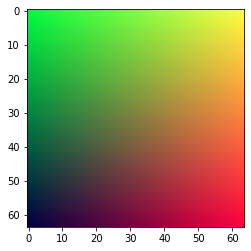

In [62]:
plt.imshow(render_image())

In [63]:
class ray:
  def __init__(self, origin, direction):
    self.origin = origin
    self.direction = direction

  def at(t):
    return self.origin + t*self.direction


def ray_color(r):
  print(r.direction)
  unit_direction = r.direction / jnp.linalg.norm(r.direction)
  t = 0.5*(unit_direction[1] + 1.0)
  return (1.0-t) * jnp.array([1.0,1.0,1.0]) + t*jnp.array([0.5, 0.7, 1.0])



3
[-1.7777778   0.71428573 -1.        ]
[-1.2698412   0.71428573 -1.        ]
[-0.7619047   0.71428573 -1.        ]
[-0.25396824  0.71428573 -1.        ]
[ 0.25396836  0.71428573 -1.        ]
[ 0.76190484  0.71428573 -1.        ]
[ 1.2698413   0.71428573 -1.        ]
[ 1.7777778   0.71428573 -1.        ]
2
[-1.7777778  0.1428572 -1.       ]
[-1.2698412  0.1428572 -1.       ]
[-0.7619047  0.1428572 -1.       ]
[-0.25396824  0.1428572  -1.        ]
[ 0.25396836  0.1428572  -1.        ]
[ 0.76190484  0.1428572  -1.        ]
[ 1.2698413  0.1428572 -1.       ]
[ 1.7777778  0.1428572 -1.       ]
1
[-1.7777778 -0.4285714 -1.       ]
[-1.2698412 -0.4285714 -1.       ]
[-0.7619047 -0.4285714 -1.       ]
[-0.25396824 -0.4285714  -1.        ]
[ 0.25396836 -0.4285714  -1.        ]
[ 0.76190484 -0.4285714  -1.        ]
[ 1.2698413 -0.4285714 -1.       ]
[ 1.7777778 -0.4285714 -1.       ]
0
[-1.7777778 -1.        -1.       ]
[-1.2698412 -1.        -1.       ]
[-0.7619047 -1.        -1.       ]
[-0.2

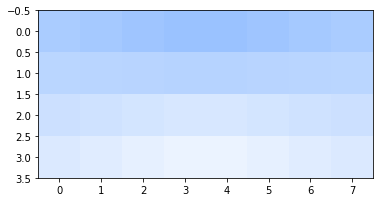

In [64]:

# Image
aspect_ratio = 16.0/9.0
image_width = 8
image_height = image_width / aspect_ratio
#Camera
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0
origin = jnp.array([0,0,0])
horizontal = jnp.array([viewport_width, 0,0])
vertical = jnp.array([0, viewport_height, 0])
lower_left_corner = origin - horizontal / 2 - vertical /2 - jnp.array([0,0,focal_length])

# @jax.jit
def render_image():

  rows = []
  for j in reversed(range(0, int(image_height))):
    row = []
    print(j)
    for i in range(0, int(image_width)):
      u = i / (image_width-1)
      v = j / (image_height-1)
      r = ray(origin, lower_left_corner+u*horizontal + v*vertical - origin)
      row.append(ray_color(r))
    rows.append(row)

  return jnp.array(rows)

plt.imshow(render_image())

In [142]:
%%time
# Image
aspect_ratio = 16.0/9.0
image_width = 400
image_height = image_width / aspect_ratio
#Camera
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0
origin = jnp.array([[0,0,0]])
horizontal = jnp.array([viewport_width, 0,0])
vertical = jnp.array([0, viewport_height, 0])
lower_left_corner = origin - horizontal / 2 - vertical /2 - jnp.array([0,0,focal_length])

# create the range of u and v values
u = jnp.arange(0, image_width, 1) / (image_width-1)
v = jnp.arange(0, jnp.array(image_height, int), 1)[::-1] / (image_height-1) # maybe remove the int() - it makes it identical to guide but doesn't give 01 range
# construct a grid from them, and stretch it into two 1D vectos so that we have a long list of u,v points
u, v = jnp.meshgrid(u,v)
u, v = u.reshape([-1]), v.reshape([-1])

uv = jnp.vstack([u,v]).T # [N,2] - pixel coords

# multiply each u component with horizontal, and v compoent with vertical. 
viewport_hv = jnp.vstack([horizontal, vertical])
direction = lower_left_corner + uv @ viewport_hv - origin
# compute unit directions by dividing by norm
unit_direction = direction / jnp.linalg.norm(direction, axis=-1)[:, jnp.newaxis]

image_shape = jnp.array([jnp.array(image_height, int), image_width, 3])

CPU times: user 42.7 ms, sys: 48.7 ms, total: 91.4 ms
Wall time: 101 ms


In [143]:
@jax.jit
def test_color(unit_direction):# make a blue fade based on y coordinate just to check it is all working
    t = 0.5*((unit_direction[:, 1]) +1.0)[:, jnp.newaxis] # [N,1]
    colors = (1-t) * jnp.array([[1.0,1.0,1.0]]) + t*jnp.array([[0.5, 0.7, 1.0]]) # [N,1] @ [1, 3] + [N,1] @ [1,3] -> [N,3]
    image = jnp.reshape(colors, image_shape)
    return image

In [144]:
image = test_color(unit_direction)

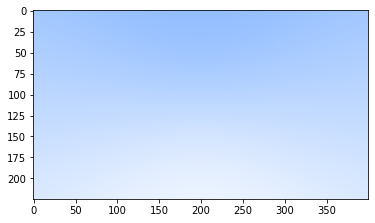

In [145]:
plt.imshow(image)

In [166]:
sphere_origin = jnp.array([[0,0,-1]])
sphere_radius = jnp.array([[0.5]])

@jax.jit
def hit_sphere(center, radius, origin, direction):
    oc = origin - center # [1,3] - [1,3]
    a = jnp.sum(direction * direction, -1) #[N, 3], [N,3] -> [N] 
    b = 2 * jnp.sum(oc * direction,-1) # [N]
    c = jnp.sum(oc * oc, -1) - radius * radius
    discriminant = b*b - (4*a*c)
    return discriminant < 0

def sphere(unit_direction):
    return jnp.array([1.0,0,0])

@jax.jit
def bg_unvec(unit_direction):
    t = 0.5*(unit_direction[1] +1.0) # [N,1]
    colors = (1-t) * jnp.array([1.0,1.0,1.0]) + t*jnp.array([0.5, 0.7, 1.0]) # [N,1] @ [1, 3] + [N,1] @ [1,3] -> [N,3]
    return colors

@jax.jit
def color(discrim, unit_direction):
    return jax.lax.cond(discrim, bg_unvec, sphere, unit_direction)


In [174]:
%time
discrim = hit_sphere(sphere_origin, sphere_radius, origin, direction)
scene = vmap(color)(discrim[0,:], unit_direction).block_until_ready()

CPU times: user 8 µs, sys: 6 µs, total: 14 µs
Wall time: 11 µs


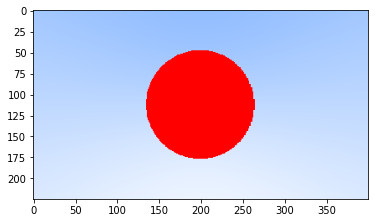

In [147]:
discrim = hit_sphere(sphere_origin, sphere_radius, origin, direction)
scene = vmap(color)(discrim[0,:], unit_direction)
image = jnp.reshape(scene, image_shape)
plt.imshow(image)

Little bit more complicated now if we want surface normals. We have to know where it hit, not just if it hit. 

To test lets make a few assumptions
- One sphere in front of us, so if there are roots then we can take the negative
-  

In [148]:
sphere_origin = jnp.array([[0,0,-1]])
sphere_radius = jnp.array([[0.5]])


def hit_sphere(center, radius, origin, direction):
    oc = origin - center # [1,3] - [1,3]
    a = jnp.sum(direction * direction, -1) #[N, 3], [N,3] -> [N] 
    b = 2 * jnp.sum(oc * direction,-1) # [N]
    c = jnp.sum(oc * oc, -1) - radius * radius
    discriminant = b*b - (4*a*c)
    # this vector tells us whether or not it was it (i.e 0 or 1)
    no_hit = discriminant < 0

    return 

def sphere(unit_direction):
    return jnp.array([1.0,0,0])

@jax.jit
def bg_unvec(unit_direction):
    t = 0.5*(unit_direction[1] +1.0) # [N,1]
    colors = (1-t) * jnp.array([1.0,1.0,1.0]) + t*jnp.array([0.5, 0.7, 1.0]) # [N,1] @ [1, 3] + [N,1] @ [1,3] -> [N,3]
    return colors

@jax.jit
def color(discrim, unit_direction):
    return jax.lax.cond(discrim, sphere, bg_unvec, unit_direction)

In [205]:
direction # [N, 3]
origin # [1,3]
#don't render anything closer than 0.01m or further than 1000m
min_ray = 0.01 
max_ray = 1000


spheres = jnp.array([[0,0,-1], [0,0,-0.5]]) # [O, 3]
sphere_colors = jnp.array([[1.0, 0, 0], [0,1,1]]) # [O, 3]
radii = jnp.array([[0.5], [0.1]]) # [O, 1]

N = len(direction)
O = len(spheres)

valid_background = jnp.ones([1,N]) # the background is always valid
valid_background_dist = valid_background*max_ray # and always max dist away
background_color = jnp.array([[0, 1.0, 0]])
all_colors = jnp.concatenate([background_color, sphere_colors]) # [1+O, 3]

def discriminant_and_roots(sphere_origin, radius, ray_origin, direction):
    oc = ray_origin - sphere_origin # [1,3] - [O,3] - > [O,3]
    a = jnp.sum(direction * direction, -1) #[N, 3], [N,3] -> [N] 
    b = 2 * oc @ direction.T # [O,3] @ [3, N] -> [O,N]
    c = jnp.sum(oc * oc, -1)[:, jnp.newaxis] - radius * radius # [O,1]
    discriminant = b*b - (4*a*c) # [O, N]

    # to calculate the roots, we will relu discriminant
    # we do this becasue otherwise the sqrt will give us nans on negative discriminants
    # this is okay, because we will use the discriminant to mask out invalid intersections, so we don't care about wrong results in those entries
    sqrt_relu_discrim = jnp.sqrt(jax.nn.relu(discriminant)) # [O, N]

    r1 = (-b - sqrt_relu_discrim) / (2*a) # [O, N]
    r2 = (-b + sqrt_relu_discrim) / (2*a) # [O, N]

    return discriminant, r1, r2

@jax.jit
def get_pixels(spheres, radii, origin, direction):
  discrim, r1, r2 = discriminant_and_roots(spheres, radii, origin, direction)  # [O, N], [O, N], [O, N]
  # The discrim tells us if the ray intersects with the spheres
  hits = discrim >= 0 # [O, N]
  # The roots tell us if these intersections are in view
  r1_in_view = r1 > min_ray # [O, N]
  r2_in_view = r2 > min_ray # [O, N]
  # The and, or tells us if the hits are both valid, and one is in view.
  valid_hits = jnp.logical_and(hits, jnp.logical_or(r1_in_view, r2_in_view)) # [O, N]
  # Now, lets transform the roots so that invalid hits are 'further away' than the background, and thus won't get selected when we get the min
  solutions = jnp.concatenate([r1[jnp.newaxis, :,:], r2[jnp.newaxis, :, :]], 0) # [2, O, N]
  # Clip wrong solutions so they are at smallest -max_ray
  solutions = jnp.clip(solutions, a_min=-max_ray) # [2, O, N]
  # Small design decision here - we correct the solutions for the spheres here and collapse it into the closer solution
  # otherwise we'd need multiple dimensions for the other types of object/background
  # Add (2*max_ray + 1) to solutions where the hits are not valid, so that they are further than the background (which will be at max_ray)
  corrected_solutions = solutions + (2*max_ray+1) * jnp.logical_not(valid_hits) # 2, O, N]
  closer_solution = jnp.min(corrected_solutions, axis=0) # [O, N]
  # Now, we add the background (and in future other shapes such as triangles) to the hits and solutions array
  valid_solutions = jnp.concatenate([valid_background, valid_hits], axis=0) # [1+ O, N]
  solutions = jnp.concatenate([valid_background_dist, closer_solution], axis = 0) # [1+O, N]
  # if the corrected solutions hadn't already been invalidated, would need to do here
  # chose the closest
  # one way of doing this would be argmin + onehot, but I think it might be faster to just do a logical not above 
  # the min? Admittedly downstream we'll then have to divide these by the number of 'closest solutions (possible if the number
  # is exactly the same), and the color will be the average of those - but I think thats ok, if it is in exactly the same place
  # avg color kinda checks out? Lets test. 
  closest = jnp.logical_not(solutions > jnp.min(solutions, 0)) # [1+O, N]
  closest = closest / jnp.sum(closest, axis=0) # / number of solutions found at exactly the same distance

  # now that we have the closest solutions, multiply by the colors to get a per pixel color
  pixels = closest.T @ all_colors # [N, 1+O] @ [1+O, 3] -> [N, 3]
  return pixels

In [206]:
%time
pixels = get_pixels(spheres, radii, origin, direction).block_until_ready()

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 11 µs


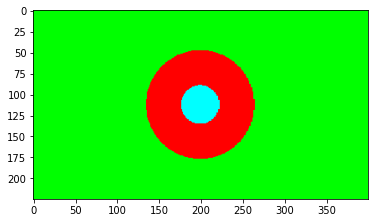

In [207]:
image = jnp.reshape(pixels, image_shape)
plt.imshow(image)

In [105]:
solutions

DeviceArray([[[0.19727986, 0.21041231, 0.22457337, ..., 0.21871217,
               0.20631254, 0.19285536]],

             [[0.19727986, 0.21041231, 0.22457337, ..., 0.21871217,
               0.20631254, 0.19285536]]], dtype=float32)

In [107]:
corrected_solutions.shape

(2, 1, 880)

In [48]:
t = jnp.array([False])
jnp.sqrt(t)

DeviceArray([0.], dtype=float32)

In [43]:
%%time
scene = vmap(color)(discrim[0,:], unit_direction)

CPU times: user 9.48 ms, sys: 9.22 ms, total: 18.7 ms
Wall time: 21.5 ms


In [44]:
%%time
x= test_color(unit_direction)

CPU times: user 2.8 ms, sys: 97 µs, total: 2.9 ms
Wall time: 5.28 ms


In [36]:
unit_direction

DeviceArray([[-0.78258556,  0.44020438, -0.44020438],
             [-0.78105766,  0.4415592 , -0.4415592 ],
             [-0.7795155 ,  0.44291964, -0.44291964],
             ...,
             [ 0.78139186, -0.44126335, -0.44126335],
             [ 0.78139186, -0.44126335, -0.44126335],
             [ 0.78376615, -0.43915302, -0.43915302]], dtype=float32)

In [324]:
%%time
discrim = hit_sphere(sphere_origin, sphere_radius, origin, direction)

CPU times: user 534 µs, sys: 1.57 ms, total: 2.11 ms
Wall time: 3.65 ms


In [285]:
sphere_origin = jnp.array([0,0,-10])
sphere_radius = 1
oc = origin[0] - sphere_origin
a = jnp.dot(direction[0], direction[0])
b = 2 * jnp.dot(oc, direction[0])
c = jnp.dot(oc, oc) - sphere_radius * sphere_radius
discriminant = b*b - 4*a*c
discriminant

DeviceArray(-1643.5555, dtype=float32)

DeviceArray([[False, False, False, ..., False, False, False]], dtype=bool)

DeviceArray([2.1600754, 1.7657671, 1.4442774, 1.2529705, 1.2529676,
             1.4479527, 1.7657574, 2.1657946, 2.0445707, 1.6224295,
             1.2650218, 1.0412867, 1.0412835, 1.2692165, 1.6224186,
             2.0506117, 2.0844965, 1.6724632, 1.3285842, 1.1176467,
             1.1176437, 1.3325788, 1.6724529, 2.090422 , 2.271672 ,
             1.9006581, 1.6063949, 1.4368378, 1.4368354, 1.6097004,
             1.9006491, 2.2771108], dtype=float32)

DeviceArray([[-1.7777778 ,  0.7109375 , -1.        ],
             [-1.2698432 ,  0.7109375 , -1.        ],
             [-0.76190865,  0.7109375 , -1.        ],
             [-0.25397408,  0.7109375 , -1.        ],
             [ 0.2539605 ,  0.7109375 , -1.        ],
             [ 0.76885307,  0.7109375 , -1.        ],
             [ 1.2698296 ,  0.7109375 , -1.        ],
             [ 1.7847222 ,  0.7109375 , -1.        ],
             [-1.7777778 ,  0.140625  , -1.        ],
             [-1.2698432 ,  0.140625  , -1.        ],
             [-0.76190865,  0.140625  , -1.        ],
             [-0.25397408,  0.140625  , -1.        ],
             [ 0.2539605 ,  0.140625  , -1.        ],
             [ 0.76885307,  0.140625  , -1.        ],
             [ 1.2698296 ,  0.140625  , -1.        ],
             [ 1.7847222 ,  0.140625  , -1.        ],
             [-1.7777778 , -0.4296875 , -1.        ],
             [-1.2698432 , -0.4296875 , -1.        ],
             [-0.76190865, -

In [39]:
@flax.struct.dataclass
class Pixel:
  """Contains data for one environment pixel."""
  pixels: jnp.ndarray

In [ ]:
def compute_pixel(carry, unused_target_t):
    i,j = carry
    act = jp.ones((batch_size, env.action_size,)) * jp.sin(i * jp.pi / 15)
    nstate = jit_env_step(state, act)
    i += 1
    return (nstate, i), StepData(state, act)

state = env.reset(rng=jp.random_prngkey(seed=0))

%%time
(state, i), data = jax.lax.scan(take_step, (state, 0), (), 100) # may need to run twice to see speedups

ವಿದಾಯ! 👋